PROCESSING RESPONSES FROM FABIAN'S MODEL

In [1]:
from utils_req import *

In [2]:
"""
Compute receptive fields using STA of responses to Monet
1. Load the Monet stimulus movies
2. Load the responses corresponding to the highest contrast bin
3. Compute STA for all neurons if 
"""
# 1. Load the Monet stimulus movies
Data = loadmat('./Monet/MonetMovies.mat')
MonetMovies = Data['MonetMovies']
del Data

Ny, Nx, T = MonetMovies.shape[0:3]
N_Contrastlevels = 10 #no. of contrast levels 
NClips = 100 # no. of clips, each presented at different contrast levels
MonetMovies = MonetMovies.reshape(Ny,Nx,T,N_Contrastlevels,NClips)
MonetMovies = MonetMovies.transpose(3,4,2,0,1)

# 2. Load the responses to highest contrast bin
Data = loadmat('./Fabee_Net_Analysis/MonetResponses/Monet_responses9.mat')
responses = Data['responses']
del Data
NNeu = responses.shape[2]

# 3. Compute STA if it has not been computed yet
fname = './Fabee_Net_Analysis/ReceptiveFields.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ReceptiveFields = Data['ReceptiveFields']
    del Data
else:
    ReceptiveFields = np.zeros([NNeu,Ny,Nx])
    lag = 1
    # obtain the RFs using STA
    for nn in tqdm(range(NNeu)):
        ReceptiveFields[nn,:,:] = np.sum(np.sum(expandN_dims(responses[:,lag:,nn],2)*(MonetMovies[9,:,:T-lag,:,:] - 127.5),axis=0),axis=0)/(NClips*(T-lag))
        
    mdict = {'ReceptiveFields':ReceptiveFields}
    savemat('./Fabee_Net_Analysis/ReceptiveFields',mdict)

In [3]:
# Compute the RF centers and quality of RFs
ReceptiveFields, RxVec, RyVec, RF_snr = ProcessReceptiveFields(ReceptiveFields)

In [4]:
"""
Estimate the local orientations and contrasts for Monet if they have not been computed already
"""

fname = './Monet/EstimatedContrast_Monet.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ChatFull = Data['ChatFull']
    fname = './Monet/EstimatedOrientation_Monet.mat'
    Data = loadmat(fname)
    OhatFull = Data['OhatFull']
    del Data
    
else:
    OhatFull = np.zeros(MonetMovies.shape)
    ChatFull = np.zeros(MonetMovies.shape)

    # paramters for estimating orientation and contrast
    ksize = 19
    sigma_o = 5
    sigma_c = 5
    rs = 1.0

    for clip in tqdm(range(NClips)):
        for nbin in range(N_Contrastlevels):
            for t in range(T):
                OhatFull[nbin,clip,t], ChatFull[nbin,clip,t] = Extract_Orientation_Contrast(np.double(MonetMovies[nbin,clip,t]),ksize, sigma_o, sigma_c, rs)
                
    # Quantize Chat and Ohat
    OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
    ChatFull = np.uint8(np.floor(256*ChatFull/np.max(ChatFull[-1])))

    # save the files
    mdict = {'OhatFull':OhatFull}
    fname = './Monet/EstimatedOrientation_Monet.mat'
    savemat(fname, mdict)

    mdict = {'ChatFull':ChatFull}
    fname = './Monet/EstimatedContrast_Monet.mat'
    savemat(fname, mdict)   

In [5]:
"""
Build 2D tuning curves, if not computed yet
"""

Nbins_o = 11 #no. of orientation bins
Nbins_c = 21 #no. of contrast bins

fname = './Fabee_Net_Analysis/TuningData.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    TuningCurves_2D = Data['TuningCurves_2D']
    BinCounts = Data['BinCounts']
    del Data

else:
    
    # now to build 2D tuning curves using the Monet stimulus

    TuningCurves_2D = np.zeros([NNeu, Nbins_c, Nbins_o]) # No. of Monet stimulus clips x No. of neurons x No. of orientation bins

    BinCounts = np.zeros([NNeu, Nbins_c, Nbins_o])

    t_st = time.time()

    for clevel in tqdm(range(N_Contrastlevels)):

        # load the responses for Monet at this contrast level
        fname = './Fabee_Net_Analysis/MonetResponses/Monet_responses' + str(clevel) + '.mat'
        Data = loadmat(fname)
        responses = Data['responses']

        # quantize the required orientation and contrast maps
        ChatReq = np.uint8(np.floor(ChatFull[clevel]*(Nbins_c/256.0))) 
        OhatReq = np.uint8(np.floor(OhatFull[clevel]*(Nbins_o/256.0))) 

        for nn in range(NNeu):

            R_nn = responses[:,:,nn].flatten() #responses of neuron nn

            # receptive field centers of neuron nn
            px = RxVec[nn]
            py = RyVec[nn]

            for ii in range(Nbins_c):

                idx_c = np.nonzero(ChatReq[:,:,py,px].flatten() == ii)[0] #find indices where contrast = ii

                for jj in range(Nbins_o):

                    idx_o = np.nonzero(OhatReq[:,:,py,px].flatten() == jj)[0] #find indices where orientation = jj
                    idx_oc = np.intersect1d(idx_c, idx_o)  # intersection of contrast and orientation bin

                    BinCounts[nn,ii,jj] = BinCounts[nn,ii,jj] + len(idx_oc)

                    TuningCurves_2D[nn,ii,jj] = TuningCurves_2D[nn,ii,jj] + np.sum(R_nn[idx_oc])
                    
      # save raw Tuning Curve data
    mdict = {'TuningCurves_2D':TuningCurves_2D, 'BinCounts': BinCounts}
    fname = './Fabee_Net_Analysis/TuningData.mat'
    savemat(fname, mdict)  


Total no. of neurons = 5701
No. of neurons selected for constructing PPCs = 3086


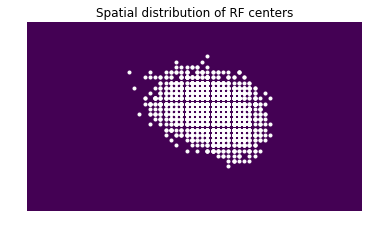

In [6]:
"""
Select the neurons with RF_snr > Th and plot the spatial distribution of the RF centers
"""

print('Total no. of neurons =', NNeu)

SNR_Threshold = 5
NIdx = np.nonzero(RF_snr > SNR_Threshold)[0]

# Retain information of only these neurons
ReceptiveFields = ReceptiveFields[NIdx]
RxVec = RxVec[NIdx]
RyVec = RyVec[NIdx]
RF_snr = RF_snr[NIdx]
NNeu = len(RF_snr)
TuningCurves_2D = TuningCurves_2D[NIdx]
BinCounts = BinCounts[NIdx]

print('No. of neurons selected for constructing PPCs =', NNeu)

plt.imshow(np.zeros([Ny,Nx]))
plt.plot(RxVec,RyVec,'w.')
plt.axis('off')
plt.title('Spatial distribution of RF centers')
plt.show()

Plotting a few example RFs


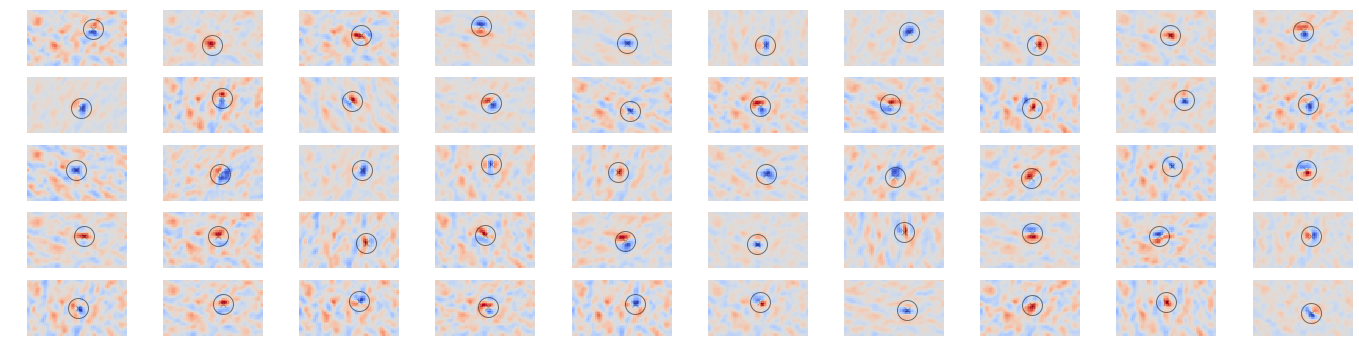

In [7]:
print('Plotting a few example RFs')
plt.subplots(5,10,figsize=(24,6))
for k in range(50):
    plt.subplot(5,10,k+1)
    nidx = np.random.randint(NNeu)
    plt.imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    plt.plot(RxVec[nidx],RyVec[nidx],'o',markersize=20,mec='k',mfc="None",alpha = 0.5)
    plt.plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    plt.axis('off')
plt.show()

In [8]:
# Pick only contrast bins 4 through 11
TuningCurves_2D = TuningCurves_2D[:,4:12,:]/BinCounts[:,4:12,:]

# orientation and contrast bin values for fitting
ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o
cont_set = (2*np.arange(Nbins_c)+1)/Nbins_c/2
cont_set = cont_set[4:12]
ori_2D,cont_2D = np.meshgrid(ori_set,cont_set)
tuningFn_inputs = np.concatenate((np.expand_dims(cont_2D.flatten(),axis=0),np.expand_dims(ori_2D.flatten(),axis=0)),axis=0)

Nbins_c = len(cont_set)
Nbins_o = len(ori_set)

In [9]:
"""
Compute fits to tuning curves
We assume tuning curves are of the form c_A*tanh(c_B*contrast + c_C)*exp(k1*cos(2(theta-mu1)) + k2*cos(4(theta-mu2)))
"""

fname = './Fabee_Net_Analysis/TuningFitInfo.mat'

if Path(fname).exists():
    Data = loadmat(fname)
    c_A = Data['c_A'].squeeze()
    c_B = Data['c_B'].squeeze()
    c_C = Data['c_C'].squeeze()
    k1 = Data['k1'].squeeze()
    k2 = Data['k2'].squeeze()
    mu1 = Data['mu1'].squeeze()
    mu2 = Data['mu2'].squeeze()
    TuningCurves_Max = Data['TuningCurves_Max'].squeeze()
    TuningCurves_Fit = Data['TuningCurves_Fit']
    FitError = Data['FitError'].squeeze()
    
else:

    # Parameters of the tuning function
    c_A = np.zeros([NNeu]) # contrast tuning amplitude
    c_B = np.zeros([NNeu]) # contrast tuning slope
    c_C = np.zeros([NNeu]) # contrast tuning offset
    k1  = np.zeros([NNeu]) # orientation tuning concentration parameter 1st order
    mu1 = np.zeros([NNeu]) # preferred orientation 1st order
    k2  = np.zeros([NNeu]) # orientation tuning concentration parameter 2nd order
    mu2 = np.zeros([NNeu]) # preferred orientation 2nd order

    # initial values and bounds for the parameters
    init_vals = [1, 1, 0, 1, np.pi/2, 0, 0]
    lb = [-3,-3,-3,0,0,0,0]
    ub = [3,3,3,5,np.pi,5,np.pi/2]


    FitError = np.zeros([NNeu])
    TuningCurves_Fit = np.zeros(TuningCurves_2D.shape)

    TuningCurves_Max = np.zeros([NNeu])

    for k in tqdm(range(NNeu)):
        TuningCurves_Max[k] = TuningCurves_2D[k].max()
        best_vals, covar = curve_fit(TuningFunction, tuningFn_inputs, TuningCurves_2D[k].reshape(-1)/TuningCurves_Max[k], p0=init_vals,bounds=(lb,ub),max_nfev=20000)
        c_A[k] = best_vals[0]
        c_B[k] = best_vals[1]
        c_C[k] = best_vals[2]
        k1[k]  = best_vals[3]
        mu1[k] = best_vals[4]
        k2[k]  = best_vals[5]
        mu2[k] = best_vals[6]

        Fit = TuningFunction(tuningFn_inputs,c_A[k],c_B[k],c_C[k],k1[k],mu1[k],k2[k],mu2[k])
        FitError[k] = MSE(Fit,TuningCurves_2D[k]/TuningCurves_Max[k])
        TuningCurves_Fit[k] = Fit.reshape(len(cont_set),len(ori_set))

    mdict = {'c_A': c_A, 'c_B': c_B, 'c_C': c_C, 'k1': k1, 'mu1': mu1, 'k2': k2, 'mu2': mu2, 'TuningCurves_Max':TuningCurves_Max, 'TuningCurves_Fit': TuningCurves_Fit, 'FitError': FitError}
    fname = './Fabee_Net_Analysis/TuningFitInfo.mat'
    savemat(fname, mdict)  

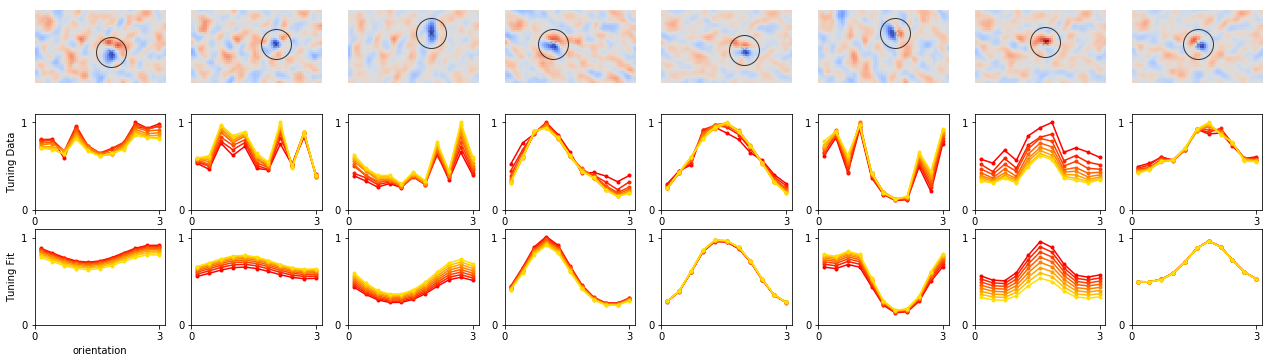

In [10]:
"""
Plot RF, tuning data and fit to tuning data for some example neurons
"""

Nplots = 8
fig, ax = plt.subplots(3,Nplots,figsize=(22,6))
for k in range(Nplots):
    nidx = np.random.randint(NNeu)
    ax[0,k].imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'o',markersize=30,mec='k',mfc="None",alpha = 0.75)
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    ax[0,k].axis('off')
    
    for n in range(Nbins_c):
        ax[1,k].plot(ori_set,TuningCurves_2D[nidx,n]/TuningCurves_Max[nidx],color=tuple([1,n*0.125,0]),marker ='.')
        ax[2,k].plot(ori_set,TuningCurves_Fit[nidx,n],color=tuple([1,n*0.125,0]),marker ='.')
    ax[1,k].set_xticks([0,3])
    ax[2,k].set_xticks([0,3])
    ax[1,k].set_yticks([0,1])
    ax[2,k].set_yticks([0,1])
    ax[1,k].axis([0,np.pi,0,1.1])
    ax[2,k].axis([0,np.pi,0,1.1])

ax[1,0].set_ylabel('Tuning Data')
ax[2,0].set_ylabel('Tuning Fit')
ax[2,0].set_xlabel('orientation')
plt.show()



Distribution of parameters of Von Mises tuning function


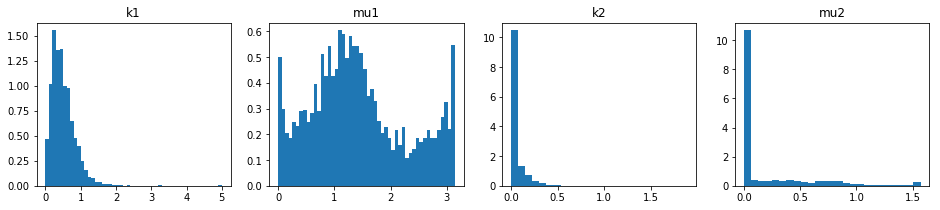

In [11]:
"""
Plot histograms of the von Mises parameters
"""
print('Distribution of parameters of Von Mises tuning function')
fig, ax = plt.subplots(1,4,figsize=(16,3))

ax[0].hist(k1,50,density=1)
ax[0].set_title('k1')
ax[1].hist(mu1,50,density=1)
ax[1].set_title('mu1')
ax[2].hist(k2,25,density=1)
ax[2].set_title('k2')
ax[3].hist(mu2,25,density=1)
ax[3].set_title('mu2')
plt.show()

In [12]:
"""
Find the Max contrast value in the Monet clips. 
We used this to normalize the contrast bins used to compute the tuning curves.
"""
# ksize = 19
# sigma_o = 5
# sigma_c = 5
# rs = 1.0
# CMax = np.zeros([NClips,T])
# for n in tqdm(range(NClips)):
#     for t in range(T):
#         image = MonetMovies[-1,n,t]
#         Chat = Extract_Orientation_Contrast(np.double(image), ksize, sigma_o, sigma_c, rs)[1]
#         CMax[n,t] = Chat.max()

# CMax = CMax.max()

CMax = np.array([93.85158576916126]) #This is the value of CMax that was computed

Compute population responses to Varma stimulus

In [13]:
"""
Load the local orientations and contrasts for Varma if they have not been computed already
"""

fname = './Fabee_Net_Analysis/Varma_Movie/EstimatedContrast_Varma.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ChatFull = Data['ChatFull']
    fname = './Fabee_Net_Analysis/Varma_Movie/EstimatedOrientation_Varma.mat'
    Data = loadmat(fname)
    OhatFull = Data['OhatFull']
    del Data
    
else:
    VarmaMovies = np.load('./Fabee_Net_Analysis/Varma_Movie/varma_movie_255.npy')
    T, NClipsVarma = VarmaMovies.shape[2:]
    OhatFull = np.zeros(VarmaMovies.shape)
    ChatFull = np.zeros(VarmaMovies.shape)

    # paramters for estimating orientation and contrast
    ksize = 19
    sigma_o = 5
    sigma_c = 5
    rs = 1.0

    for clip in tqdm(range(NClipsVarma)):
            for t in range(T):
                OhatFull[:,:,t,clip], ChatFull[:,:,t,clip] = Extract_Orientation_Contrast(np.double(VarmaMovies[:,:,t,clip]),ksize, sigma_o, sigma_c, rs)
                
    # Quantize Chat and Ohat
    OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
    ChatFull = np.uint8(np.floor(256*ChatFull/CMax))

    # save the files
    mdict = {'OhatFull':OhatFull}
    fname = './Fabee_Net_Analysis/Varma_Movie/EstimatedOrientation_Varma.mat'
    savemat(fname, mdict)

    mdict = {'ChatFull':ChatFull}
    fname = './Fabee_Net_Analysis/Varma_Movie/EstimatedContrast_Varma.mat'
    savemat(fname, mdict)   

100%|██████████| 3086/3086 [00:01<00:00, 2343.87it/s]


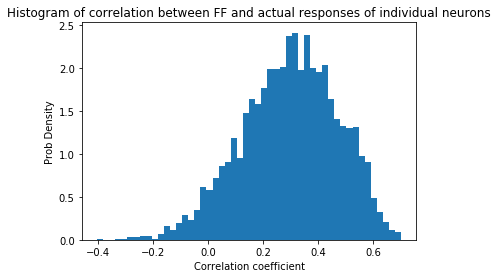

In [14]:
"""
Load the Varma responses and compute the feedforward responses
"""
VarmaResponses = np.load('./Fabee_Net_Analysis/VarmaResponses/varma_neural_activations_255.npy')
VarmaResponses = VarmaResponses[:,:,NIdx] #choose only neurons with good RFs
FFResponses = np.zeros(VarmaResponses.shape)

OhatFull = OhatFull.transpose([3,2,0,1])
ChatFull = ChatFull.transpose([3,2,0,1])

for nn in tqdm(range(NNeu)):
    px = RxVec[nn]
    py = RyVec[nn]
    C_input = np.expand_dims(ChatFull[:,:,py,px]/256,axis=0)
    O_input = np.expand_dims(OhatFull[:,:,py,px]*np.pi/256,axis=0)
    tuningFn_inputs = np.concatenate((C_input, O_input),axis=0)
    FFResponses[:,:,nn] = TuningFunction(tuningFn_inputs,c_A[nn],c_B[nn],c_C[nn],k1[nn],mu1[nn],k2[nn],mu2[nn])*TuningCurves_Max[nn]
    
# compute correlation between the responses
CorrVec = np.zeros([NNeu])
for nn in tqdm(range(NNeu)):
    CorrVec[nn] = np.corrcoef(FFResponses[:,:,nn].flatten(),VarmaResponses[:,:,nn].flatten())[0,1]
    
plt.hist(CorrVec,50,density=1)
plt.xlabel('Correlation coefficient')
plt.ylabel('Prob Density')
plt.title('Histogram of correlation between FF and actual responses of individual neurons')
plt.show()

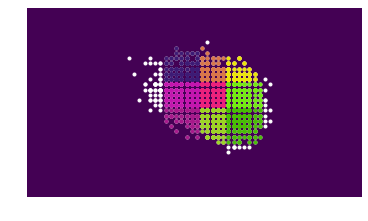

[253. 405. 133. 295. 664. 307. 126. 452. 365.]


In [15]:
"""
Construct the PPCs based on RF centers of the neurons
"""

X_C = np.int(np.round(RxVec.mean()))
Y_C = np.int(np.round(RyVec.mean()))

id_PPC = []

# Pick a Mx x My grid of groups(Mx and My should be odd)
# Each individual group is itself a MxM grid of pixels
M = 5
Mx = 3
My = 3
Mxb2 = np.int((Mx-1)/2)
Myb2 = np.int((Mx-1)/2)
Mb2 = np.int((M-1)/2)

x0 = X_C - Mb2 -M*Mxb2
y0 = Y_C - Mb2 -M*Myb2

x0 = x0   #adding offset based on manual observation

PopulationCenters = np.zeros([Mx*My,2])

N_populations = 0

for ix in range(Mx):
    if ix == 0:
        id_x = pick_indices(RxVec,x0 + ix*M-2, x0 + (ix+1)*M - 1)
    elif ix == Mx-1:
        id_x = pick_indices(RxVec,x0 + ix*M, x0 + (ix+1)*M + 1)
    else:
        id_x = pick_indices(RxVec,x0 + ix*M, x0 + (ix+1)*M - 1)       
    for iy in range(My):
        if iy == 0:
            id_y = pick_indices(RyVec,y0 + iy*M-2, y0 + (iy+1)*M - 1)
        elif iy == My -1:
            id_y = pick_indices(RyVec,y0 + iy*M, y0 + (iy+1)*M + 1)
        else:
            id_y = pick_indices(RyVec,y0 + iy*M, y0 + (iy+1)*M - 1)
        id_PPC.append(np.intersect1d(id_x,id_y))
        PopulationCenters[N_populations,0] = x0 + ix*M + Mb2
        PopulationCenters[N_populations,1] = y0 + iy*M + Mb2
        N_populations = N_populations + 1
        
# plot the RF centers and show grouping of the PPCs
plt.figure()
plt.imshow(np.zeros([Ny,Nx]))
plt.plot(np.round(RxVec),np.round(RyVec),'w.')
for i in range(N_populations):
    plt.plot(np.round(RxVec[id_PPC[i]]),np.round(RyVec[id_PPC[i]]),color=tuple(np.random.rand(3)),marker='.',linestyle='None')
    
plt.axis('off')
plt.show()

# Find the no. of neurons in each population
NNeu_Pops = np.zeros([N_populations])
for i in range(len(id_PPC)):
    NNeu_Pops[i] = len(id_PPC[i])

print(NNeu_Pops)


In [16]:
"""
Create population responses
"""

NClipsVarma = VarmaResponses.shape[0]

FFResponses = FFResponses.transpose(0,2,1)
VarmaResponses = VarmaResponses.transpose(0,2,1)

# Compute the cos and sin statistics for feedforward and actual neural responses

FF_cos1 = np.zeros([NClipsVarma,N_populations,T])
FF_sin1 = np.zeros([NClipsVarma,N_populations,T])
FF_cos2 = np.zeros([NClipsVarma,N_populations,T])
FF_sin2 = np.zeros([NClipsVarma,N_populations,T])

R_cos1 = np.zeros([NClipsVarma,N_populations,T])
R_sin1 = np.zeros([NClipsVarma,N_populations,T])
R_cos2 = np.zeros([NClipsVarma,N_populations,T])
R_sin2 = np.zeros([NClipsVarma,N_populations,T])

AverageNeuronsinPPC = np.mean(NNeu_Pops)

normalizeByNNeu = 1 #if we want to scale the number of neurons in each population to the average across populations

# Add extra dimensions to Mu and K vectors
k1_E = expandN_dims(k1,2).transpose([1,0,2])
k2_E = expandN_dims(k2,2).transpose([1,0,2])
mu1_E = expandN_dims(mu1,2).transpose([1,0,2])
mu2_E = expandN_dims(mu2,2).transpose([1,0,2])

for ii in range(len(id_PPC)):
    
    idx = id_PPC[ii]
    k1_PPC = k1_E[:,idx,:]
    k2_PPC = k2_E[:,idx,:]
    mu1_PPC = mu1_E[:,idx,:]
    mu2_PPC = mu2_E[:,idx,:]

    if normalizeByNNeu:
        Z = len(idx)/AverageNeuronsinPPC
    else:
        Z = 1
        
    FF_cos1[:,ii,:] = np.sum(FFResponses[:,idx,:]*k1_PPC*np.cos(2*mu1_PPC),axis=1)/Z
    FF_sin1[:,ii,:] = np.sum(FFResponses[:,idx,:]*k1_PPC*np.sin(2*mu1_PPC),axis=1)/Z
    FF_cos2[:,ii,:] = np.sum(FFResponses[:,idx,:]*k2_PPC*np.cos(4*mu2_PPC),axis=1)/Z
    FF_sin2[:,ii,:] = np.sum(FFResponses[:,idx,:]*k2_PPC*np.sin(4*mu2_PPC),axis=1)/Z
    
    R_cos1[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k1_PPC*np.cos(2*mu1_PPC),axis=1)/Z
    R_sin1[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k1_PPC*np.sin(2*mu1_PPC),axis=1)/Z
    R_cos2[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k2_PPC*np.cos(4*mu2_PPC),axis=1)/Z
    R_sin2[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k2_PPC*np.sin(4*mu2_PPC),axis=1)/Z
    

In [17]:
"""
Compute the correlations between the population responses
"""
PopCorrCoeff_c1 = np.zeros([N_populations])
PopCorrCoeff_s1 = np.zeros([N_populations])
PopCorrCoeff_c2 = np.zeros([N_populations])
PopCorrCoeff_s2 = np.zeros([N_populations])

for k in range(N_populations):
    PopCorrCoeff_c1[k] = np.corrcoef(FF_cos1[:,k,:].flatten(),R_cos1[:,k,:].flatten())[0,1]
    PopCorrCoeff_c2[k] = np.corrcoef(FF_cos2[:,k,:].flatten(),R_cos2[:,k,:].flatten())[0,1]
    PopCorrCoeff_s1[k] = np.corrcoef(FF_sin1[:,k,:].flatten(),R_sin1[:,k,:].flatten())[0,1]
    PopCorrCoeff_s2[k] = np.corrcoef(FF_sin2[:,k,:].flatten(),R_sin2[:,k,:].flatten())[0,1]

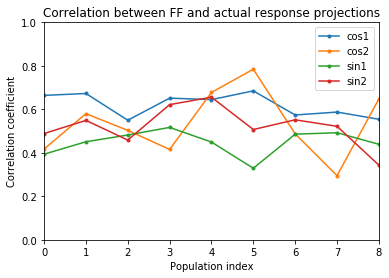

In [18]:
plt.plot(PopCorrCoeff_c1,'.-')
plt.plot(PopCorrCoeff_c2,'.-')
plt.plot(PopCorrCoeff_s1,'.-')
plt.plot(PopCorrCoeff_s2,'.-')
plt.axis([0,8,0,1])
plt.xlabel('Population index')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between FF and actual response projections')
plt.legend(['cos1', 'cos2', 'sin1', 'sin2'])
plt.show()


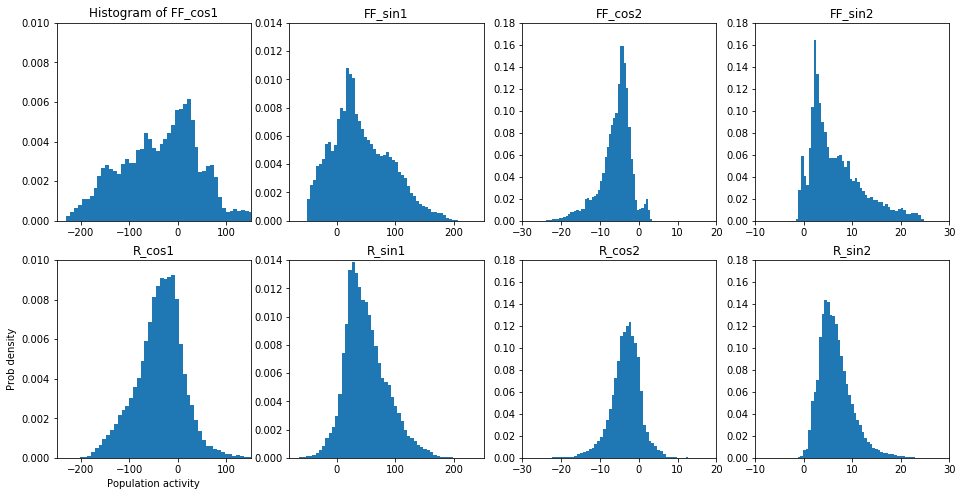

In [19]:
"""
Histogram of population responses
"""
fig, ax = plt.subplots(2,4,figsize=(16,8))

ax[0,0].hist(FF_cos1.flatten(),50,density=1)
ax[0,0].set_title('Histogram of FF_cos1')
ax[0,0].axis([-250,150,0,0.01])
ax[1,0].hist(R_cos1.flatten(),50,density=1)
ax[1,0].set_title('R_cos1')
ax[1,0].set_xlabel('Population activity')
ax[1,0].set_ylabel('Prob density')
ax[1,0].axis([-250,150,0,0.01])

ax[0,1].hist(FF_sin1.flatten(),50,density=1)
ax[0,1].set_title('FF_sin1')
ax[0,1].axis([-80,250,0,0.014])
ax[1,1].hist(R_sin1.flatten(),50,density=1)
ax[1,1].set_title('R_sin1')
ax[1,1].axis([-80,250,0,0.014])

ax[0,2].hist(FF_cos2.flatten(),50,density=1)
ax[0,2].set_title('FF_cos2')
ax[0,2].axis([-30,20,0,0.18])
ax[1,2].hist(R_cos2.flatten(),50,density=1)
ax[1,2].set_title('R_cos2')
ax[1,2].axis([-30,20,0,0.18])

ax[0,3].hist(FF_sin2.flatten(),50,density=1)
ax[0,3].set_title('FF_sin2')
ax[0,3].axis([-10,30,0,0.18])
ax[1,3].hist(R_sin2.flatten(),50,density=1)
ax[1,3].set_title('R_sin2')
ax[1,3].axis([-10,30,0,0.18])


plt.show()

In [20]:
# """
# Save the population responses
# """
# mdict = {'R_cos1': R_cos1, 'R_sin1': R_sin1, 'FF_cos1': FF_cos1, 'FF_sin1': FF_sin1, 'R_cos2': R_cos2, 'R_sin2': R_sin2, 'FF_cos2': FF_cos2, 'FF_sin2': FF_sin2}
# fname = './Fabee_Net_Analysis/PopulationStatisticsData_FabeeNet.mat'
# savemat(fname, mdict)


PROCESS CIFAR IMAGES BY THESE POPULATION CODES

In [21]:
"""
Load the CIFAR features
"""
# Load the CIFAR features

fname = './Platinum_mouse_GNN_data/EstimatedCIFARFeatures.mat'
Data = loadmat(fname)
CMapReq_CIFAR = Data['CMapReq']
OMapReq_CIFAR = Data['OMapReq']
del Data

In [22]:
"""
Align the RF centers with 9x9 grid of CIFAR features
"""
xx = (np.float64(RxVec) - X_C)*3.0/5 + 4
id_x = np.nonzero(xx>8)[0]
xx[id_x] = 8
id_x = np.nonzero(xx<0)[0]
xx[id_x] = 0
del id_x

yy = (np.float64(RyVec) - Y_C)*3.0/5 + 4
id_y = np.nonzero(yy>8)[0]
yy[id_y] = 8
id_y = np.nonzero(yy<0)[0]
yy[id_y] = 0
del id_y

# Aligned RF centers
RxVec_A = np.round(xx)
RyVec_A = np.round(yy)
del xx, yy


In [23]:
"""
Compute projections of the mean population responses based on stimulus features

1. Compute the mean responses based on the tuning curves
"""

normalizeByNNeu = 1 #scale the population parameters to average no. of neurons in each population

Nimages = CMapReq_CIFAR.shape[0]

# 1. Compute mean responses FF_CIFAR for the neurons in the populations, for all the images
FF_CIFAR = np.zeros([Nimages,NNeu])

for nn in tqdm(range(NNeu)):
    px = np.int(RxVec_A[nn])
    py = np.int(RyVec_A[nn])
    C_input = np.expand_dims(CMapReq_CIFAR[:,py,px]/256,axis=0)
    O_input = np.expand_dims(OMapReq_CIFAR[:,py,px]*np.pi/256,axis=0)
    tuningFn_inputs = np.concatenate((C_input, O_input),axis=0)
    FF_CIFAR[:,nn] = TuningFunction(tuningFn_inputs,c_A[nn],c_B[nn],c_C[nn],k1[nn],mu1[nn],k2[nn],mu2[nn])*TuningCurves_Max[nn]

        

100%|██████████| 3086/3086 [00:15<00:00, 196.21it/s]


In [24]:
"""
Compute the population responses for CIFAR images
"""

# Compute the cos and sin statistics for feedforward and actual neural responses

FF_cos1_CIFAR = np.zeros([N_populations,Nimages])
FF_sin1_CIFAR = np.zeros([N_populations,Nimages])
FF_cos2_CIFAR = np.zeros([N_populations,Nimages])
FF_sin2_CIFAR = np.zeros([N_populations,Nimages])


normalizeByNNeu = 1 #if we want to scale the number of neurons in each population to the average across populations

# Add extra dimensions to Mu and K vectors
k1_E = np.expand_dims(k1,axis=0)
k2_E = np.expand_dims(k2,axis=0)
mu1_E = np.expand_dims(mu1,axis=0)
mu2_E = np.expand_dims(mu2,axis=0)

for ii in tqdm(range(len(id_PPC))):    
    idx = id_PPC[ii]
    k1_PPC = k1_E[:,idx]
    k2_PPC = k2_E[:,idx]
    mu1_PPC = mu1_E[:,idx]
    mu2_PPC = mu2_E[:,idx]

    if normalizeByNNeu:
        Z = len(idx)/AverageNeuronsinPPC
    else:
        Z = 1
        
    FF_cos1_CIFAR[ii,:] = np.sum(FF_CIFAR[:,idx]*k1_PPC*np.cos(2*mu1_PPC),axis=1)/Z
    FF_sin1_CIFAR[ii,:] = np.sum(FF_CIFAR[:,idx]*k1_PPC*np.sin(2*mu1_PPC),axis=1)/Z
    FF_cos2_CIFAR[ii,:] = np.sum(FF_CIFAR[:,idx]*k2_PPC*np.cos(4*mu2_PPC),axis=1)/Z
    FF_sin2_CIFAR[ii,:] = np.sum(FF_CIFAR[:,idx]*k2_PPC*np.sin(4*mu2_PPC),axis=1)/Z
    

100%|██████████| 9/9 [00:20<00:00,  2.23s/it]


In [25]:
"""
Save the feedforward population responses for CIFAR
"""
mdict = {'FF_cos1': FF_cos1_CIFAR, 'FF_sin1': FF_sin1_CIFAR, 'FF_cos2': FF_cos2_CIFAR, 'FF_sin2': FF_sin2_CIFAR}
fname = './Fabee_Net_Analysis/FF_Projections_CIFAR_FabeeNet.mat'
savemat(fname, mdict)